# Data Preparation for BiteChat

* Data Collection: Google Maps
* Data Transformation
    * Step 1: Extract popular dishes and special dietary information
    * Step 2: Review Summarization
    * Step 3: Create Embeddings
* Data Index: Elasticsearch Cloud


## Collect data from Google Maps

In [ ]:
import requests
import json
import os
from dotenv import load_dotenv
from urllib.parse import quote
import time

In [ ]:
def find_in_Seattle(text:str):
    state = 'WA'
    # done = 98105
    zip_codes = [98101, 98102, 98103, 98104, 98106, 98107, 98108, 98109, 98110, 98111, 98112, 98114, 98115, 98116, 98117, 98118, 98119, 98121, 98122, 98124, 98125, 98126, 98131, 98132, 98133, 98134, 98136, 98138, 98144, 98145, 98146, 98148, 98154, 98155, 98158, 98160, 98161, 98164, 98166, 98168, 98171, 98174, 98177, 98178, 98188, 98198, 98199]
    
    query_list = [f"{text} in {state} {zip}" for zip in zip_codes]
    return query_list

def gmaps_places_Seattle(text_list:list, key=None):
    load_dotenv()
    api_key = os.getenv("GOOGLE-API-KEY") if os.getenv("GOOGLE-API-KEY") else key
    
    all_results = []

    for text in text_list:
        query_list = find_in_Seattle(text)
        for query in query_list:
            previous_token = None
            next_page_token = None

            # Google Maps Place API endpoint
            encoded_query = quote(query)
            url = 'https://maps.googleapis.com/maps/api/place/textsearch/json'
            search_url = f"{url}?query={encoded_query}&key={api_key}"
            
            num_places = len(all_results)
            seen_place_ids = [dic['place_id'] for dic in all_results]
            
            while True:
                # Check if there's a next_page_token and it's different from the previous token
                if next_page_token and next_page_token != previous_token:            
                    time.sleep(2)  # Delay for 2 seconds as per Google's recommendation
                    paginated_url = f"{search_url}&pagetoken={next_page_token}"
                    response = requests.get(paginated_url)
                else:
                    response = requests.get(search_url)
                
                # Extend the unique places to the all_results list
                if response.status_code == 200:
                    result = response.json()
                    for dic in result['results']:
                        if dic['place_id'] not in seen_place_ids:
                            all_results.append(dic)
                            seen_place_ids.append(dic['place_id'])
                    
                    # Update previous_token with the current next_page_token before fetching the new next_page_token
                    previous_token = next_page_token
                    next_page_token = result.get('next_page_token')

                    if not next_page_token:
                        num_type_places = len(all_results) - num_places
                        print(f'{query} has {num_type_places} places. {search_url}')
                        break  # Exit the loop if there's no next page token
                else:
                    print(f"Error fetching data: {response.status_code}: {response.text}")
                    break  # Exit the loop in case of an error
    
    return all_results

def filtered_places(results:list, zipcodes:list):
    '''
    Filter the list based on the conditions: rating > 3.8 and business_status == 'OPERATIONAL'

    Parameters:
    - results: list of dictionaries containing the places data
    - zipcodes (optional): list of zipcodes to filter the results
    '''

    filtered_results = [
        {
            'place_id': result['place_id'],
            'name': result['name'],
            'rating': result['rating'],
            'user_ratings_total': result.get('user_ratings_total'), 
            'price_level': result.get('price_level'),  # Using .get() as not all places may have a price level
            'opening_hours': result.get('opening_hours'),
            'types': result['types'],
            'photos': result.get('photos'),
            'formatted_address': result['formatted_address'],
            'geometry': result['geometry']   
        }
        for result in results
        if result.get('rating', 0) > 3.8 and result.get('business_status') == 'OPERATIONAL' and (not zipcodes or any(zipcode in result['formatted_address'] for zipcode in zipcodes))
    ]
    return filtered_results

def gmaps_place_details(place_id:str, fields, key=None):    
    load_dotenv()
    api_key = os.getenv("GOOGLE-API-KEY") if os.getenv("GOOGLE-API-KEY") else key

    url = f'https://places.googleapis.com/v1/places/{place_id}?fields={fields}&key={api_key}'

    response = requests.get(url)

    if response.status_code == 200:
        result = response.json()
    else:
        result = None
    
    return result

def clean_details(detail_results:list, save_path='places_details_cleaned.json'):
    details_cleaned = []
    for place in detail_results:
        if place.get('reviews'):
            review_list = []
            for review in place['reviews']:
                if 'text' in review:
                    list = [
                        {
                            "publishTime":review['publishTime'],
                            "rating":review['rating'],
                            "text":review['text']['text']
                        }
                    ]
                    review_list.extend(list)

        info = {
            "id":place['id'],
            "name":place['displayName']['text'],
            "rating":place['rating'],
            "userRatingCount":place['userRatingCount'],
            "priceLevel":place.get('priceLevel'),
            "businessStatus":place['businessStatus'], 
            "types":place['types'],
            "phone":place.get('nationalPhoneNumber'),
            "formattedAddress":place['formattedAddress'],
            "website":place.get('websiteUri'),
            "location":place['location'],
            "takeout": place.get('takeout'),
            "delivery": place.get('delivery'),
            "dineIn": place.get('dineIn'),
            "curbsidePickup": place.get('curbsidePickup'),
            "reservable": place.get('reservable'),
            "servesBreakfast": place.get('servesBreakfast'),
            "servesLunch": place.get('servesLunch'),
            "servesDinner": place.get('servesDinner'),
            "servesBeer": place.get('servesBeer'),
            "servesWine": place.get('servesWine'),
            "servesBrunch": place.get('servesBrunch'),
            "servesVegetarianFood": place.get('servesVegetarianFood'),
            "outdoorSeating": place.get('outdoorSeating'),
            "liveMusic": place.get('liveMusic'),
            "menuForChildren": place.get('menuForChildren'),
            "servesCocktails": place.get('servesCocktails'),
            "servesCoffee": place.get('servesCoffee'),
            "goodForChildren": place.get('goodForChildren'),
            "allowsDogs": place.get('allowsDogs'),
            "restroom":place.get('restroom'),
            "goodForGroups": place.get('goodForGroups'),
            "goodForWatchingSports":place.get('goodForWatchingSports'),
            "paymentOptions":place.get('paymentOptions'),
            "parkingOptions": place.get('parkingOptions'),
            "accessibilityOptions": place.get('accessibilityOptions')
        }
        info['openingHours'] = place['currentOpeningHours']['weekdayDescriptions'] if place.get('currentOpeningHours') else None
        info["editorialSummary"] = place.get('editorialSummary')['text'] if place.get('editorialSummary') else None
        info["reviews"] = review_list

        details_cleaned.append(info)

        with open(save_path, 'w') as f:
            json.dump(details_cleaned, f, indent=4)
    
    return details_cleaned

In [ ]:
food_type_list = ['american_restaurant', 'bakery','bar','barbecue_restaurant','brazilian_restaurant','breakfast_restaurant','brunch_restaurant','cafe','chinese_restaurant','coffee_shop','fast_food_restaurant','french_restaurant','greek_restaurant','hamburger_restaurant','ice_cream_shop','indian_restaurant','indonesian_restaurant','italian_restaurant','japanese_restaurant','korean_restaurant','lebanese_restaurant','meal_delivery','meal_takeaway','mediterranean_restaurant','mexican_restaurant','middle_eastern_restaurant','pizza_restaurant','ramen_restaurant','restaurant','sandwich_shop','seafood_restaurant','spanish_restaurant','steak_house','sushi_restaurant','thai_restaurant','turkish_restaurant','vegan_restaurant','vegetarian_restaurant','vietnamese_restaurant']
food_type_list = ['restaurant', 'bakery', 'bar', 'cafe', 'dessert', 'meal delievery', 'meal takeaway']

results = gmaps_places_Seattle(text_list=food_type_list)
print(f"Total places fetched: {len(results)}")

with open('places.json', 'w') as f:
    json.dump(results, f, indent=4)

## Step 1: Extract popular dishes and special dietary information

In [ ]:
def generate_prompt(input_variable):
    p = """
    <s>[INST] 

    Please extract the name of dishes with a positive sentiment in "food" and special dietary in "dietary" from the given review. Return in JSON format with the following keys: "food" and "dietary". If there is no food or dietary information, return null for the respective key.

    # Examples:
    Tonight was our first time trying Sand Point Grill since moving to North 
    Seattle and we will definitely be back. We loved the food (got the house burger 
    and schnitzel sandwich, both were filling and delicious), the family friendly 
    atmosphere, and friendly and prompt service from Michael, our server. 
    Everyone in the place looked happy. Five stars!
    ***
        "food": ["Sand Point Grill", "house burger", "schnitzel sandwich"],
        "dietary": null
    ***

    I ordered the Farmer\u2019s veggie hash bowl with gluten-free toast, their delicious homemade? raspberry jam and I added the maple pork sausage to the hash. Make sure to order the eggs over-easy or over-medium so you get the nice runny yolk, or the dish would be a bit dry.
    ***
        "food": ["Farmer\u2019s veggie hash bowl", "gluten-free toast", "raspberry jam", "maple pork sausage"],
        "dietary": ["vegetarian", "gluten-free"]
    ***

    Good restaurant with a nice atmosphere. 
    ***
        "food": null
        "dietary": null
    ***

    Review:
    {input_variable} %s

    ONLY RETURN THE JSON OBJECT. DO NOT PRINT ANYTHING ELSE.

    [/INST]


    """

    return p, input_variable

In [ ]:
def parse_json_with_fallback(json_str):
    try:
        return json.loads(json_str), True
    except json.JSONDecodeError as e:
        print(json_str)
        if '}' not in json_str:
            json_str = json_str + '}'
        else:
            json_str = json_str[:json_str.find('}')+1]
        
        if '{' not in json_str:
            json_str = '{' + json_str

        try:
            return json.loads(json_str), True
        except json.JSONDecodeError as e:
            print(f"Failed to decode JSON: {e}")
        return None, False

def model_prompt_config(model, temperature, prompt, input_variable):
    llm = Ollama(model= model,
                temperature=temperature,)

    prompt = PromptTemplate(
        input_variables=[input_variable],
        template= prompt,

    )

    chain = LLMChain(llm = llm, prompt=prompt, verbose=False)
    return chain
    
def extract_dishes_dietary(model_set, review_text, idx_list = None):
    result_list = []
    skip_index = []
    max_retries = 3
    retry_delay = 2
    
    for i in range(len(review_text)):
        index = idx_list[i] if idx_list else i
        retry_count = 0
        while retry_count < max_retries:
            result = model_set.run(review=review_text[i])
            result_dict, sucess = parse_json_with_fallback(result)
            if sucess:
                result_dict['idx'] = index
                print(result_dict)
                result_list.append(result_dict)
                break
            else:
                print(f"Failed attemp {index}")
                time.sleep(retry_delay)
                retry_count += 1
        if retry_count == max_retries:
            print(f"Failed to decode JSON for review at index {index} after {max_retries} retries. Skipping review.")
            skip_index.append(i)
    return result_list

def chunker(seq, indices, size):
    """Yield successive chunks from seq alongside with corresponding indices."""
    for pos in range(0, len(seq), size):
        yield seq[pos:pos + size], indices[pos:pos + size]

def chunk_processor(model_set, review_list, indices_list, save=True, save_path="output/"):
    for i, (chunk, indices_chunk) in enumerate(tqdm(chunker(review_list, indices_list, 100), total=len(review_list)//100)):
        print(f'Processing chunk {i+1}')
        # Pass the chunk and the corresponding indices to your function
        result = extract_dishes_dietary(model_set, chunk, indices_chunk)
        if save:
            with open(f"{save_path}food_dietary_{i+1}.json", "w") as f:
                json.dump(result, f, indent=4)

In [ ]:
prompt, input_variable = generate_prompt(input_variable='review')
chain = model_prompt_config(model="mistral",
                            temperature=0.2, 
                            prompt=prompt, 
                            input_variable=input_variable)

with open("reviews_text_98105.json", "r") as f:
    reviews = json.load(f)

chunk_processor(chain, reviews, range(0, len(reviews)), save=True, save_path="data/")

## Step 2: Review Summarization

In [ ]:
from transformers import pipeline
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
def plot_length_distribution(text_list, bins=20):
    # Calculate the lengths of combined reviews for each id
    review_lengths = [sum(len(review) for review in reviews) for reviews in text_list]

    # Plotting the length distribution using histogram
    plt.hist(review_lengths, bins=bins, edgecolor='black')
    plt.xlabel('Length of Individual Reviews')
    plt.ylabel('Frequency')
    plt.title('Length Distribution of Individual Reviews')
    plt.grid(True)
    plt.show()

def check_length_long(text):
    # individual review threshold > 100
    # concatenated review threshold > 300
    return True if len(text)>300 else False

def summarization(text_list):
    # individual review max_length threshold = 120
    # concatenated review max_length threshold = 400
    result_list=[]
    summarizer = pipeline("summarization", model='facebook/bart-large-cnn')
    for text in tqdm(text_list):
        if check_length_long(text):
            result = summarizer(text, max_length = 400, min_length=100, do_sample=False)[0]['summary_text']
        else:
            result = text
        result_list.append(result)
    return result_list

def chunker(seq, indices, size):
    for pos in range(0, len(seq), size):
        yield seq[pos:pos + size], indices[pos:pos + size]

def chunk_processor(data_list, indices_list, save=True, save_path="output/"):
    for i, (chunk, indices_chunk) in enumerate(chunker(data_list, indices_list, 100)):
        print(f'Processing Chunk {i+1}')
        result = summarization(chunk)
        if save:
            with open(f"{save_path}summary_{i+1}.json", "w") as f:
                json.dump(result, f)
            print(f'Save {save_path}summary_{i+1}.json')

def combine_reviews(review_list, col_name):
    combined_reviews = {}
    for item in review_list:
        review_id = item['id']
        review_text = item[col_name]
        if review_id in combined_reviews:
            combined_reviews[review_id].append(review_text)
        else:
            combined_reviews[review_id] = [review_text]
    return combined_reviews

def plot_length_distribution_combined(data_dict):
    length_list = []
    for idx, key in enumerate(data_dict):
        length = 0
        for item in data_dict[key]:
            length += len(item)
        length_list.append(length)

    # Plotting the length distribution using histogram
    plt.hist(length_list, bins=10, edgecolor='black')
    plt.xlabel('Length of Combined Reviews')
    plt.ylabel('Frequency')
    plt.title('Length Distribution of Combined Reviews')
    plt.grid(True)
    plt.show()

def combine_json(start, end, file_prefix):
    summary_list = []
    for i in range(start, end):
        with open(f"{file_prefix}{i}.json", "r") as f:
            summary = json.load(f)
            summary_list.extend(summary)
    print(len(summary_list))
    return summary_list

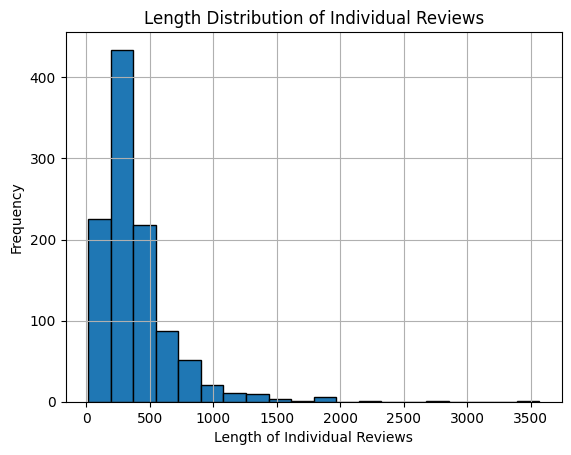

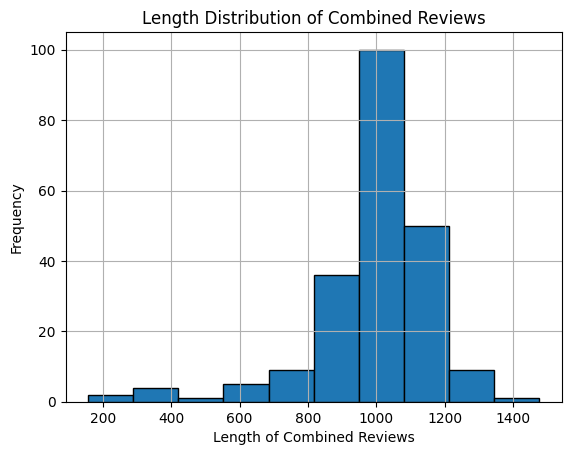

## Step 3: Create Embeddings

In [ ]:
from sentence_transformers import SentenceTransformer
import json

def create_embeddings(text):
    """
    Create embeddings for text with 384 dimension
    """
    model = SentenceTransformer('intfloat/e5-small-v2')
    embeddings = model.encode(text, normalize_embeddings=True)
    return embeddings.tolist()  # Convert ndarray to a list

In [ ]:
review_embeddings = []
for item in data:
    embeddings = create_embeddings(item)
    review_embeddings.append(embeddings)
print(len(review_embeddings))


with open('review_embeddings.json', 'w') as f:
    json.dump(embeddings_list, f)

## Build index in Elasticsearch cloud

In [ ]:
from dotenv import load_dotenv
from elasticsearch import Elasticsearch, helpers
import json
import os

In [ ]:
def create_elasticsearch_conntection():
    load_dotenv()

    ElasticSearch_ID = os.getenv('ELASTICSEARCH_ID')          
    ElasticSearch_PWD = os.getenv('ELASTICSEARCH_PWD')    
    client = Elasticsearch(
        cloud_id = ElasticSearch_ID,
        basic_auth=("elastic", ElasticSearch_PWD) 
    )
    return client

def create_or_update_index_mapping(client, index, create=True)
    index_mapping = {
    "properties": {
        "id": {
        "type": "keyword"
        },
        "name": {
        "type": "text"
        },
        "rating": {
        "type": "float"
        },
        "userRatingCount": {
        "type": "integer"
        },
        "priceLevel": {
        "type": "keyword"
        },
        "businessStatus": {
        "type": "keyword"
        },
        "types": {
        "type": "keyword"
        },
        "phone": {
        "type": "keyword"
        },
        "formattedAddress": {
        "type": "text"
        },
        "website": {
        "type": "keyword"
        },
        "location": {
        "type": "geo_point"
        },
        "parking":{
        "type": "text"
        },
        "payment": {
        "type": "text"
        },
        "accessibility": {
        "type": "text"
        },
        "openingHours": {
        "type": "text"
        },
        "takeout": {
        "type": "boolean"
        },
        "delivery": {
        "type": "boolean"
        },
        "dineIn": {
        "type": "boolean"
        },
        "curbsidePickup": {
        "type": "boolean"
        },
        "reservable": {
        "type": "boolean"
        },
        "servesBreakfast": {
        "type": "boolean"
        },
        "servesLunch": {
        "type": "boolean"
        },
        "servesDinner": {
        "type": "boolean"
        },
        "servesBeer": {
        "type": "boolean"
        },
        "servesWine": {
        "type": "boolean"
        },
        "servesBrunch": {
        "type": "boolean"
        },
        "servesVegetarianFood": {
        "type": "boolean"
        },
        "outdoorSeating": {
        "type": "boolean"
        },
        "liveMusic": {
        "type": "boolean"
        },
        "menuForChildren": {
        "type": "boolean"
        },
        "servesCocktails": {
        "type": "boolean"
        },
        "servesCoffee": {
        "type": "boolean"
        },
        "goodForChildren": {
        "type": "boolean"
        },
        "allowsDogs": {
        "type": "boolean"
        },
        "restroom": {
        "type": "boolean"
        },
        "goodForGroups": {
        "type": "boolean"
        },
        "goodForWatchingSports": {
        "type": "boolean"
        },
        "food":{
        "type": "text"
        }, 
        "review_vector": {
        "type": "dense_vector",
        "dims": 384,   # e5-small-v2's dimensions
        "index": "true",
        "similarity": "cosine"
        },
        "service":{
        "type": "text"
        }, 
        "editorialSummary": {
        "type": "text"
        },
        "reviews":{
        "type": "text"
        }, 
        "info":{
        "type": "text"
        }

    }
    }

    print(len(index_mapping['properties'].keys()))
    print(index_mapping['properties'].keys())

    if create:
        # Create index mapping
        client.indices.create(index=index, mappings=index_mapping) 
    else:
        # Update the index mapping
        client.indices.put_mapping(index=index, body=index_mapping)
    
# Bulk insert documents into the index
def generate_to_bulk_api_format(data_list=metadata, index_name='bitechat'):
    for item in data_list:
        keys = list(item.keys())
        yield {
            "_index": index_name,
            "_id": item['id'],
            "_source": {key: item[key] for key in keys if key != 'id'}
        }

In [ ]:
# Create index
with open('metadata_98105_info.json', 'r') as f:
    metadata = json.load(f)

start = 0
end = len(metadata)
batch_size = 100
for batch_start in range(start, end, batch_size):
    batch_end = min(batch_start + batch_size, end)
    batch_document = metadata[batch_start:batch_end]
    actions = generate_to_bulk_api_format(batch_document)
    try:
        successes, errors = helpers.bulk(client, actions)
        if errors:
            print("Errors encountered during bulk indexing:", errors)
        print(f"Successfully indexed {successes} documents.")
    except Exception as e:
        print("Error indexing batch:", e)
    